In [3]:
from sqlalchemy import create_engine, inspect
import subprocess
import pandas as pd
import geopandas as gpd
import psycopg2
from psycopg2 import sql
import plotly.express as px
import matplotlib.pyplot as plt
import time
import sys

# define database connection
db_name = "urbanmining"
username = "postgres"
password = "Tunacompany5694!"
host = "localhost"  # or your host if it's not local
port = "5432"  # default port for PostgreSQL

connection_string = f"postgresql://{username}:{password}@{host}:{port}/{db_name}"
engine = create_engine(connection_string)

# Visualize embodied emissions (2011 - now)
- total embodied emissions 
- embodied emissions for one municipality
- embodied emissions for all municipalities (highlight highest and lowest municipalities)

In [22]:
# get embodied emissions for housing in NL
query = ''' 
SELECT year, status, SUM(emissions_embodied_tons) AS emissions_embodied_tons
FROM emissions_embodied_housing_nl 
WHERE year >= 2012 AND year <= 2022
GROUP BY year, status
ORDER BY year, status
'''
df_byStatus = pd.read_sql_query(query, engine)
def translate_status(x): 
    if x == 'Bouw gestart': 
        return 'Construction'
    elif x == 'Pand gesloopt': 
        return 'Demolition'
    elif x == 'Verbouwing pand': 
        return 'Renovation'
    else: 
        return x 
df_byStatus.status = df_byStatus.status.map(lambda x: translate_status(x))

# line chart for embodied emissions per year
fig = px.bar(df_byStatus, x='year', y='emissions_embodied_tons', color = 'status', title='Embodied emissions per year for housing in NL')
fig.show()

df = df_byStatus.groupby('year').sum().emissions_embodied_tons.reset_index()

# calculate cumulative emissions and carbon budget
carbon_budget = 41000000 # carbon budget for only embodied emissions. budget for all emissions is 112,000,000 tons 
df['cumulative_emissions'] = df['emissions_embodied_tons'].cumsum()
df['carbon_budget'] = carbon_budget - df['cumulative_emissions']

# line chart for cumulative embodied emissions and carbon budget 
fig = px.line(df, x='year', y=['cumulative_emissions', 'carbon_budget'], title='Cumulative embodied emissions for housing in NL')
fig.update_yaxes(range=[0, None])
fig.show()

Top ten municipalities: ['Amsterdam', 'Utrecht', 'Eindhoven', "'s-Gravenhage", 'Rotterdam', 'Tilburg', 'Almere', 'Groningen', 'Ede', 'Breda']
Bottom ten municipalities: ['Pekela', 'Ameland', 'Doesburg', 'Oostzaan', 'Montfoort', 'Waterland', 'Terschelling', 'Rozendaal', 'Vlieland', 'Schiermonnikoog']


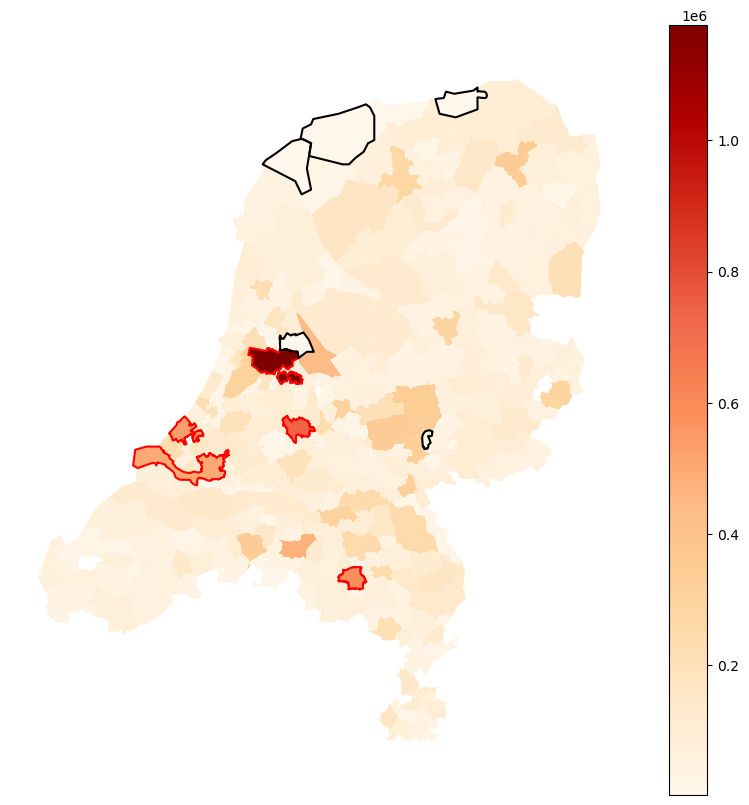

In [23]:
# embodied emissions total
query = ''' 
WITH emissions AS (
	SELECT municipality, SUM(emissions_embodied_tons) AS emissions_embodied_tons
	FROM emissions_embodied_housing_nl 
	WHERE year >= 2011 AND year <= 2022 -- AND municipality = 'Delft'
	GROUP BY municipality
)
SELECT e.*, g.geom
FROM emissions e 
JOIN nl_gemeentegebied g 
ON e.municipality = g.naam
ORDER BY e.emissions_embodied_tons DESC
'''
gdf = gpd.read_postgis(query, engine)

# top and bottom five municipalities 
top_five = gdf.head(10).municipality.tolist()
bottom_five = gdf.tail(10).municipality.tolist()
print(f'Top ten municipalities: {top_five}')
print(f'Bottom ten municipalities: {bottom_five}')

# plot on map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='emissions_embodied_tons', legend=True, cmap='OrRd', ax=ax)
gdf.head().boundary.plot(ax=ax, color='red')
gdf.tail().boundary.plot(ax=ax, color='black')
ax.axis('off')
plt.show()

In [36]:
# horizontal bar chart for embodied emissions per municipality
fig = px.bar(gdf, x='emissions_embodied_tons', y='municipality', title='Embodied emissions per municipality for housing in NL')
fig.update_layout(width=800, height=600)
fig.show()

In [33]:
# by status
query = f'''
SELECT municipality, status, SUM(sqm) AS sqm, SUM(emissions_embodied_tons) AS emissions_embodied_tons
FROM emissions_embodied_housing_nl
WHERE 
    municipality IN (
        'Amsterdam', 'Utrecht', 'Eindhoven', \'\'\'s-Gravenhage', 'Rotterdam',
        'Tilburg', 'Almere', 'Groningen', 'Ede', 'Breda'
        )
    AND year >= 2012 AND year < 2024
GROUP BY municipality, status
'''
df = pd.read_sql_query(query, engine)
df.status = df.status.map(lambda x: translate_status(x))
municipality_order = ['Amsterdam', 'Utrecht', 'Eindhoven', "'s-Gravenhage", 'Rotterdam', 'Tilburg', 'Almere', 'Groningen', 'Ede', 'Breda']
status_order = ['Construction', 'Demolition', 'Renovation']

color_discrete_map = {
    'Construction': px.colors.qualitative.Plotly[0],  # Construction
    'Demolition': px.colors.qualitative.Plotly[1],   # Demolition
    'Renovation': px.colors.qualitative.Plotly[2] # Renovation
}

fig = px.bar(df, x='emissions_embodied_tons', y='municipality', color='status',  
             title='Embodied emissions by status for top ten municipalities (2011 - 2024)', 
             category_orders={'municipality': municipality_order, 'status': status_order},
             color_discrete_map=color_discrete_map)
fig.update_layout(width=1000)
fig.show()

In [37]:
# by status

bottom_ten = ['Pekela', 'Ameland', 'Doesburg', 'Oostzaan', 'Montfoort', 'Waterland', 
              'Terschelling', 'Rozendaal', 'Vlieland', 'Schiermonnikoog']

query = f'''
SELECT municipality, status, SUM(sqm) AS sqm, SUM(emissions_embodied_tons) AS emissions_embodied_tons
FROM emissions_embodied_housing_nl
WHERE 
    municipality IN (
        'Pekela', 'Ameland', 'Doesburg', 'Oostzaan', 'Montfoort', 'Waterland', 
        'Terschelling', 'Rozendaal', 'Vlieland', 'Schiermonnikoog'
        )
    AND year >= 2012 AND year < 2024
GROUP BY municipality, status
'''
df = pd.read_sql_query(query, engine)
df.status = df.status.map(lambda x: translate_status(x))
municipality_order = ['Pekela', 'Ameland', 'Doesburg', 'Oostzaan', 'Montfoort', 'Waterland', 
                      'Terschelling', 'Rozendaal', 'Vlieland', 'Schiermonnikoog']
status_order = ['Construction', 'Demolition', 'Renovation']

color_discrete_map = {
    'Construction': px.colors.qualitative.Plotly[0],  # Construction
    'Demolition': px.colors.qualitative.Plotly[1],   # Demolition
    'Renovation': px.colors.qualitative.Plotly[2] # Renovation
}

fig = px.bar(df, x='emissions_embodied_tons', y='municipality', color='status',  
             title='Embodied emissions by status for bottom ten municipalities (2011 - 2024)', 
             category_orders={'municipality': municipality_order, 'status': status_order},
             color_discrete_map=color_discrete_map)
fig.update_layout(width=1000)
fig.show()

In [ ]:
query = ''' 
SELECT year, municipality, SUM(emissions_embodied_tons) AS emissions_embodied_tons
FROM emissions_embodied_housing_nl 
WHERE year >= 2011 AND year <= 2022 
GROUP BY year, municipality
ORDER BY year, municipality
'''
df = pd.read_sql_query(query, engine)
df['cumulative_emissions'] = df.sort_values('year').groupby('municipality')['emissions_embodied_tons'].cumsum()
df = df[df['municipality'].isin(top_five + bottom_five)]

fig = px.line(df, x='year', y='cumulative_emissions', color='municipality', title='Cumulative embodied emissions per year for housing in NL')
fig.show()

In [ ]:
# emissions for one municipality
def get_data_for_municipality(municipality_name, engine): 
    query = f''' 
    SELECT year, SUM(emissions_embodied_tons) AS emissions_embodied_tons
    FROM emissions_embodied_housing_nl 
    WHERE year >= 2011 AND year <= 2022 AND municipality = '{municipality_name}'
    GROUP BY year
    '''
    df = pd.read_sql_query(query, engine)    
    df['cumulative_emissions'] = df['emissions_embodied_tons'].cumsum()
    
    return df 

def plot_embodiedEmissions_perYear_forMunicipality(df, municipality_name, type='cumulative'):
    if type == 'cumulative':
        title = f'Cumulative embodied emissions per year for housing in {municipality_name}'
        y = 'cumulative_emissions'
    else: 
        title = 'Embodied emissions per year for housing in ' + municipality_name
        y = 'emissions_embodied_tons'
    
    fig = px.line(df, x='year', y=y, title=title)
    fig.show()

municipality_name = 'Amsterdam'
df = get_data_for_municipality(municipality_name, engine)
plot_embodiedEmissions_perYear_forMunicipality(df, municipality_name, 'n cumulative')
plot_embodiedEmissions_perYear_forMunicipality(df, municipality_name, 'cumulative')